In [1]:
import numpy as np
import scipy as sp
import scipy.signal as sig
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, regularizers, callbacks
from data_wrangling.datamanager import DataLoader
from tqdm.notebook import tqdm

In [2]:
dl = DataLoader()
data = dl.get_fcx2(['s1'])

In [3]:
X1 = data['s1']['data']
mn = X1.mean(0).reshape((1, -1))
st = X1.std (0).reshape((1, -1))
X1 = (X1 - mn) / st
X1.shape

(1303952, 73)

In [4]:
fs = 1000

idxs_train_test_split = int(len(X1) * 0.7)

p_in  = 100
p_out = 10

step  = 20 

idxs_train = np.arange(0, idxs_train_test_split - p_out - p_in, step)

X_train = np.stack([
    X1[idx : idx + p_in]
    for idx in idxs_train
])

Y_train = np.stack([
    X1[idx + p_in : idx + p_in + p_out]
    for idx in idxs_train
])

X_train.shape, Y_train.shape

((45633, 100, 73), (45633, 10, 73))

In [5]:
model = keras.Sequential([
    layers.Input(X_train.shape[1:]),
    layers.Bidirectional(
        layers.LSTM(128)
    ),
    layers.RepeatVector(Y_train.shape[1]),
    layers.LSTM(128, return_sequences = True),
    layers.Bidirectional(
        layers.LSTM(64, return_sequences = True)
    ),
    layers.Dense(Y_train.shape[-1])
])

model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               206848    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           197120    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 128)           98816     
_________________________________________________________________
dense (Dense)                (None, 10, 73)            9417      
Total params: 512,201
Trainable params: 512,201
Non-trainable params: 0
_________________________________________________________________


In [6]:
hist = model.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 2048,
    validation_split = 0.2,
    callbacks = [callbacks.EarlyStopping(min_delta = 1e-3, patience = 2)]
)

Epoch 1/50
18/18 [==============================] - 8s 236ms/step - loss: 0.9009 - val_loss: 0.5994
Epoch 2/50
18/18 [==============================] - 3s 170ms/step - loss: 0.4760 - val_loss: 0.3846
Epoch 3/50
18/18 [==============================] - 3s 167ms/step - loss: 0.3192 - val_loss: 0.2857
Epoch 4/50
18/18 [==============================] - 3s 167ms/step - loss: 0.2388 - val_loss: 0.2271
Epoch 5/50
18/18 [==============================] - 3s 170ms/step - loss: 0.1911 - val_loss: 0.1882
Epoch 6/50
18/18 [==============================] - 3s 167ms/step - loss: 0.1599 - val_loss: 0.1665
Epoch 7/50
18/18 [==============================] - 3s 172ms/step - loss: 0.1395 - val_loss: 0.1518
Epoch 8/50
18/18 [==============================] - 3s 167ms/step - loss: 0.1264 - val_loss: 0.1361
Epoch 9/50
18/18 [==============================] - 3s 169ms/step - loss: 0.1206 - val_loss: 0.1332
Epoch 10/50
18/18 [==============================] - 3s 168ms/step - loss: 0.1100 - val_loss: 0.1210

In [7]:
hist = model.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 128,
    validation_split = 0.3,
    callbacks = [callbacks.EarlyStopping(min_delta = 5e-4, patience = 3)]
)

Epoch 1/50
250/250 [==============================] - 6s 24ms/step - loss: 0.0723 - val_loss: 0.0757
Epoch 2/50
250/250 [==============================] - 6s 23ms/step - loss: 0.0639 - val_loss: 0.0727
Epoch 3/50
250/250 [==============================] - 6s 23ms/step - loss: 0.0592 - val_loss: 0.0689
Epoch 4/50
250/250 [==============================] - 6s 24ms/step - loss: 0.0559 - val_loss: 0.0702
Epoch 5/50
250/250 [==============================] - 6s 24ms/step - loss: 0.0689 - val_loss: 0.0776
Epoch 6/50
250/250 [==============================] - 6s 24ms/step - loss: 0.0608 - val_loss: 0.0670
Epoch 7/50
250/250 [==============================] - 6s 24ms/step - loss: 0.0560 - val_loss: 0.0684
Epoch 8/50
250/250 [==============================] - 6s 24ms/step - loss: 0.0534 - val_loss: 0.0651
Epoch 9/50
250/250 [==============================] - 6s 24ms/step - loss: 0.0516 - val_loss: 0.0633
Epoch 10/50
250/250 [==============================] - 6s 24ms/step - loss: 0.0506 - val_lo

In [8]:
pred = []
real = []
for idx in range(idxs_train_test_split, len(X1) - p_out - p_in, p_out):
    x = X1[idx : idx + p_in].reshape((1, p_in, -1))
    y = X1[idx + p_in : idx + p_in + p_out]
    pred.append(x)
    real.append(y)
    
per_stride = 2048
strides = 1 + len(pred) // per_stride
pred = np.concatenate([
    model(
        np.concatenate(pred[stride * per_stride : (stride + 1) * per_stride])
    ).numpy()
    for stride in range(strides)
])

real = np.stack(real)

pred.shape, real.shape, ((pred - real) ** 2).mean()

((39108, 10, 73), (39108, 10, 73), 0.08164080490456534)

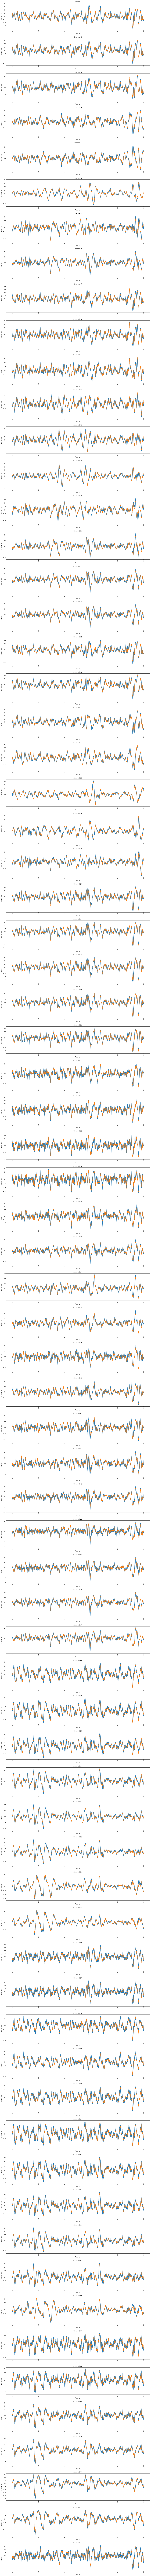

In [9]:
n_channels = real.shape[-1]
plt.figure(figsize = (20, 5 * n_channels))
n_steps = 1000
plt.subplots_adjust(hspace = 0.3)

for chan in range(real.shape[-1]):

    plt.subplot(n_channels, 1, chan + 1)
    plt.title(f'Channel {chan + 1}')
    plt.plot(
        np.linspace(0, p_out * n_steps / fs, n_steps * p_out), 
        real[:n_steps, :, chan].flatten(), 
        linewidth = 3
    )
    plt.plot(
        np.linspace(0, p_out * n_steps / fs, n_steps * p_out), 
        pred[:n_steps, :, chan].flatten(), 
        linewidth = 1
    )
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [V]')
    
plt.show()